In [43]:
import os
import sys
import numpy as np
sys.path.append('/nas/k8s/dev/research/doyoungi/croptype_cls/S4A-Models')
from model.utae import UTAE
from pathlib import Path

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.plugins import DDPPlugin
import torch

from utils.PAD_datamodule import PADDataModule
from utils.tools import font_colors
from utils.settings.config import RANDOM_SEED, CROP_ENCODING, LINEAR_ENCODER, CLASS_WEIGHTS, BANDS

import matplotlib.pyplot as plt

In [49]:
root_dir = '/nas/k8s/dev/research/doyoungi/croptype_cls/S4A-Models/dataset/newdata'
root_dir = Path(root_dir)
# Create Data Modules
dm = PADDataModule(
    root_dir=root_dir,
    scenario=2,
    band_mode='nrgb',
    linear_encoder=LINEAR_ENCODER,
    start_month=4,
    end_month=10,
    batch_size=4,
    num_workers=4,
    binary_labels=False,
    return_parcels=True,
)

dm.setup('test')

Rootdir: /nas/k8s/dev/research/doyoungi/croptype_cls/S4A-Models/dataset/newdata
Scenario: 2, MODE: test, length of datasets: 1364
Acquired Data Month: From 4 to 10
Data shape: [T, C, H, W] (6, 4, 64, 64)


In [50]:
dataloader = dm.test_dataloader()

In [51]:
resume_from_checkpoint = '/nas/k8s/dev/research/doyoungi/croptype_cls/S4A-Models/logs/utae/utae_epoch300_scenario2/run_20230203072022/checkpoints/epoch=300-step=171269.ckpt'
run_path = os.path.dirname(os.path.dirname(resume_from_checkpoint))


crop_encoding_rev = {v: k for k, v in CROP_ENCODING.items()}
crop_encoding = {k: crop_encoding_rev[k] for k in LINEAR_ENCODER.keys() if k != 0}
crop_encoding[0] = 'Background/Other'

model = UTAE.load_from_checkpoint(resume_from_checkpoint,
                                      map_location=torch.device('cpu'),
                                      run_path=run_path,
                                      linear_encoder=LINEAR_ENCODER,
                                      crop_encoding=False,
                                      checkpoint_epoch=300)

In [52]:
for idx, batch in enumerate(dataloader):
    img = batch['medians']
    ann = batch['labels']
    parcel = batch['parcels']
    
    # print(ann.shape)
    b, t, c, h, w = img.shape
    x = img.view(b, -1, h, w)
    y = model(x)
    break

In [53]:
pred = torch.exp(y.to(torch.long))
pred = torch.clamp(pred, 0, max(LINEAR_ENCODER.values()))

In [54]:
pred = torch.argmax(pred, dim=1)
pred = pred.detach().cpu().numpy() # [0]

In [55]:
ann = ann.detach().cpu().numpy() # [0]
parcel = parcel.detach().cpu().numpy() # [0]

In [57]:
correct = pred == ann
incorrect = pred != ann
correct_map = np.zeros(correct.shape)
correct_map[correct] = 2
correct_map[incorrect] = 1
correct_map = correct_map * parcel

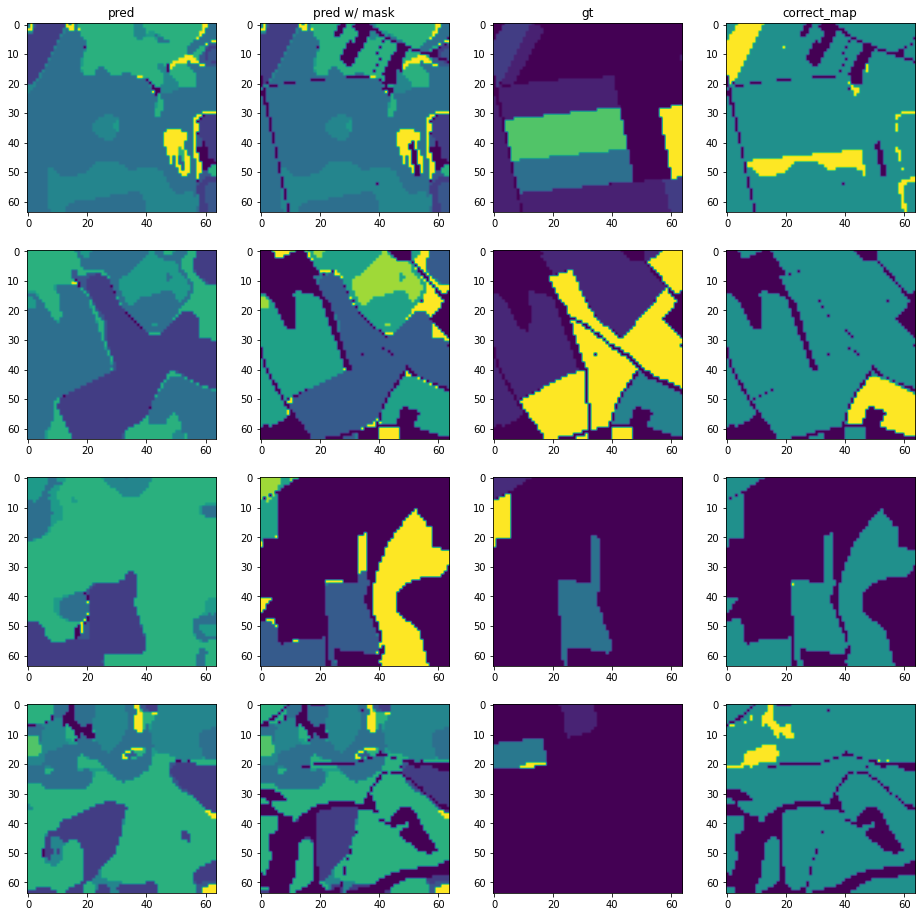

In [61]:
fig, ax = plt.subplots(4,4, figsize=(16,16))
for i in range(4):
    ax[i][0].imshow(pred[i])
    ax[i][1].imshow(pred[i] * parcel[i])
    ax[i][2].imshow(ann[i])
    ax[i][3].imshow(correct_map[i])
title = ['pred', 'pred w/ mask', 'gt', 'correct_map']
for a, t in zip(ax[0], title):
    a.set_title(t)
plt.show()